In this file, all the models are trained and tested on the predefined train-test split.
Furthermore, the feature selection methods are evaluated on the logistic regression model for different hyperparameters.

In [1]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.4.0"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.4.0\bin\x64" + ";" + os.environ["PATH"]

In [60]:
from abc import abstractmethod
from matplotlib.patches import Patch
from sklearn.metrics import confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import ttest_rel
from methods.helper import *
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score, roc_curve, matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from rpy2.robjects import r, pandas2ri
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import auc
from methods.feature_selection import *
from tqdm import tqdm
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Loading the data and predefined training and testing split. I will be using here both the concatenated omics dataset and the proteomics dataset.


In [3]:
# Loading data
lipidomics, metabolomics, proteomics = load_data()
X_train, X_test, Y_train, Y_test = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=2)

lipidomics_train, lipidomics_test = get_train_test_split_dataset(lipidomics)
metabolomics_train, metabolomics_test = get_train_test_split_dataset(metabolomics)
proteomics_train, proteomics_test = get_train_test_split_dataset(proteomics)

# Remove the class column from the datasets
lipidomics_train = lipidomics_train.drop(columns=["TwoClass", "RID", "ThreeClass"])
lipidomics_test = lipidomics_test.drop(columns=["TwoClass", "RID", "ThreeClass"])
metabolomics_train = metabolomics_train.drop(columns=["TwoClass", "RID", "ThreeClass"])
metabolomics_test = metabolomics_test.drop(columns=["TwoClass", "RID", "ThreeClass"])
proteomics_train = proteomics_train.drop(columns=["TwoClass", "RID", "ThreeClass"])
proteomics_test = proteomics_test.drop(columns=["TwoClass", "RID", "ThreeClass"])

# Add the names of the columns for the Y and create a df
Y_train = pd.DataFrame(Y_train, columns=["TwoClass"])
Y_test = pd.DataFrame(Y_test, columns=["TwoClass"])

In [4]:
class Model:
    """
    An abstract class representing a model.
    All the models should inherit from this class.
    """
    
    def __init__(self, seed):
        """
        Initialize the model with the seed.
        """
        self.seed = seed
        self.model = None
    
    @abstractmethod
    def fit(self, x_train, y_train):
        """
        Fit the model to the training data.
        :param x_train: training features
        :param y_train: training labels
        :return: fitted model
        """
        pass
    
    @abstractmethod
    def predict(self, x):
        """
        Predict the labels for the given features.
        :param x: features
        :return: predicted labels (binary and continuous)
        """
        pass
    
    @abstractmethod
    def get_metrics(self, x_test, y_test):
        """"
        Get the metrics of the model including accuracy, F1, precision, recall, AUC, and MCC.
        :param x_test: test features
        :param y_test: test labels
        :return: dictionary of metrics
        """
        pass
    
    def get_ROC(self, x_test, y_test):
        """
        Get the ROC curve data.
        :param x_test: test features
        :param y_test: test labels
        :return: fpr, tpr, thresholds
        """
        y_pred_continuous = self.model.predict_proba(x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_continuous)
        return fpr, tpr, thresholds   

# Logistic Regression L1

In [5]:
class LogisticRegressionModel(Model):
    
    def __init__(self, c=0.7, solver='saga', seed=42):
        """
        Initialize the logistic regression model
        :param c: the regularization parameter
        :param solver: the optimization algorithm
        :param seed: the random seed
        """
        super().__init__(seed)
        self.model = LogisticRegression(
            max_iter=1000, multi_class='ovr', class_weight='balanced',
            penalty='l1', solver=solver, C=c, random_state=seed
        )
            
    def fit(self, train_x, train_y):
        # Fit the model
        self.model.fit(train_x, train_y.values.ravel())
        
    def tune(self, train_x, train_y):
        """
        Tune the model using GridSearchCV to find the best hyperparameters.
        """
        hyperparameters = {
            'C': [0.001, 0.01, 0.1, 0.3, 0.7, 1, 3, 5, 10]
        }
        grid_search = GridSearchCV(
            LogisticRegression(
                max_iter=1000, multi_class='ovr', class_weight='balanced',
                penalty='l1', solver='saga', random_state=self.seed
            ),
            hyperparameters, cv=5, scoring='f1'
        )
        grid_search.fit(train_x, train_y.values.ravel())
        self.model = grid_search.best_estimator_
        return grid_search.best_params_['C']

            
    def predict(self, x):
        return self.model.predict(x)
    
    def get_metrics(self, x_test, y_test, plot=False):
        y_pred = self.model.predict(x_test)
        y_pred_continuous = self.model.predict_proba(x_test)[:, 1]
        plot_confusion_matrix(y_test['TwoClass'], y_pred) if plot else None
        return {
            "Accuracy": round(accuracy_score(y_test, y_pred), 3),
            "F1": round(f1_score(y_test, y_pred, average='weighted'), 3),
            "Precision": round(precision_score(y_test, y_pred, average='weighted'), 3),
            "Recall": round(recall_score(y_test, y_pred, average='weighted'), 3),
            "AUC": round(roc_auc_score(y_test, y_pred_continuous), 3),
            "MCC": round(matthews_corrcoef(y_test, y_pred), 3)
        }

In [6]:
# Standarize the data for logistic regression
X_train_stan = standardize(X_train)
X_test_stan = standardize(X_test)

proteomics_train_stan = standardize(proteomics_train)
proteomics_test_stan = standardize(proteomics_test)

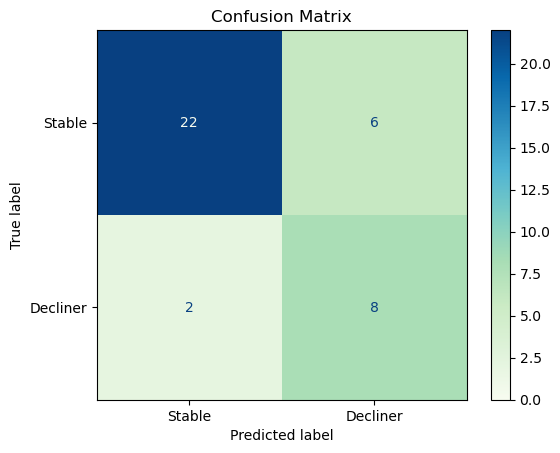

{'Accuracy': 0.789, 'F1': 0.799, 'Precision': 0.826, 'Recall': 0.789, 'AUC': 0.746, 'MCC': 0.535}


In [7]:
# ALL OMICS

# Tuning the hyperparameters
# c = LogisticRegressionModel().tune(X_train_stan, Y_train)
# print(c)
logistic_model_all_omics = LogisticRegressionModel(0.2)
logistic_model_all_omics.fit(X_train_stan, Y_train)
metric_logistic_all_omics = logistic_model_all_omics.get_metrics(
    X_test_stan, Y_test, plot=True)
print(metric_logistic_all_omics)

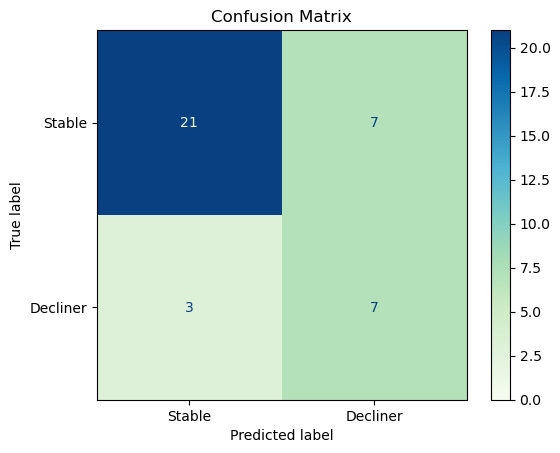

{'Accuracy': 0.737, 'F1': 0.749, 'Precision': 0.776, 'Recall': 0.737, 'AUC': 0.714, 'MCC': 0.411}


In [8]:
# PROTEOMICS
# Tune the hyperparameters
# c = LogisticRegressionModel().tune(proteomics_train_stan, Y_train)
# print(c)
logistic_model_proteomics = LogisticRegressionModel(0.3)
logistic_model_proteomics.fit(proteomics_train_stan, Y_train)
metric_logistic_proteomics = logistic_model_proteomics.get_metrics(
    proteomics_test_stan, Y_test, plot=True)
print(metric_logistic_proteomics)

### Testing L1 Logistic Regression with Feature Selection

For each feature selection method, I will determine the most optimal:
- k (percentage of features to keep)
- c (regularization parameter)

After hyperparameter tuning, I will compare the F1 and MCC scores for different k values.

In [9]:
def get_boruta_model(x_train, y_train, x_test, y_test):
    """
    This method uses the Boruta method to select the features and then tests the model with the selected features.
    :param x_train: the training features
    :param y_train: the training labels
    :param x_test: the testing features
    :param y_test: the testing labels
    :return: the dictionary of metrics
    """
    # Filter the features
    boruta_features = boruta_filtering(x_train, y_train)
    x_train_boruta, x_test_boruta = x_train[boruta_features], x_test[boruta_features]
    print("Number of features selected by Boruta: ", len(boruta_features))

    # Test the model with the selected features (no regularization)
    lg_model = LogisticRegressionModel(100000000000, seed=42)
    lg_model.fit(x_train_boruta, y_train)
    boruta_metrics = lg_model.get_metrics(x_test_boruta, y_test)
    return {
        "F1": boruta_metrics['F1'],
        "MCC": boruta_metrics['MCC'],
        'Number of Features': len(boruta_features)
    }

def plot_supervised_grid_search(result_df):
    """
    Plots a heatmap of the F1 scores for different methods and feature percentages.

    Parameters:
    result_df (pd.DataFrame): DataFrame with columns 'K', 'F1', and 'Method'.
                              'K' represents the percentage of features maintained.
                              'F1' represents the F1 score.
                              'Method' represents the method used.
    """
    
    # Changing the K column - percentage of features maintained instead of the original k
    result_df['K'] = round(result_df['K'] * 100)
    
    # Pivot the DataFrame to get Methods as rows, K as columns, and F1 scores as values
    pivot_table = result_df.pivot("Method", "K", "F1")
    
    # Plot the heatmap
    sns.set(style="whitegrid")
    plt.subplots(figsize=(8, 6))
    plot = sns.heatmap(
        pivot_table, annot=True,
        cmap='coolwarm', linecolor='white', fmt=".3f", annot_kws={"size": 8},
        cbar_kws={'label': 'F1 Score'}, vmax=1
    )

    plot.set_ylabel('Supervised Feature Selection Method', fontsize=12)
    plot.set_xlabel('Percentage of the Features Maintained', fontsize=12)
    plot.set_yticklabels(plot.get_yticklabels(), fontsize=10, rotation=0)
    plt.tight_layout()
    plt.show()

In [10]:
def test_feature_selection_k_ranges(
        x_train, y_train, x_test, y_test,
        feature_selector, feature_selector_name):
    """
    This method finds the score for the hyperparameters: k (ratio of features to keep)
    and for each saves the best c (regularization parameter) for the logistic regression model.
    :param feature_selector: the feature selection method
    :param feature_selector_name: the name of the feature selection method
    :param x_train: the training features
    :param y_train: the training labels
    :param x_test: the testing features
    :param y_test: the testing labels
    :return: the best model specification and the DataFrame of the F1 scores
    """
    
    # Get the range of thresholds for the filtering method to be tested
    k_range = np.arange(0.1, 1.1, 0.1)
    
    # Initialize the best model specification
    best_model_spec = None
    k_f1 = pd.DataFrame(columns=['K', 'F1', 'Method', 'Number of Features'])

    for i in tqdm(range(len(k_range)), desc="Running tests"):
        k = k_range[i]
        # Filter the features
        filtered_features = feature_selector(x_train, y_train, k)
        x_train_filtered = x_train[filtered_features]
        x_test_filtered = x_test[filtered_features]
        tuned_c = LogisticRegressionModel(seed=42).tune(x_train_filtered, y_train)
        log_model = LogisticRegressionModel(tuned_c, seed=42)
        log_model.fit(x_train_filtered, y_train)
        metrics = log_model.get_metrics(x_test_filtered, y_test)
        
        spec = {
            'C': tuned_c, 'F1': metrics['F1'], 
            'MCC': metrics['MCC'], 'K': k, 'Number of Features': len(filtered_features)}
        
        if i == 0:
            best_model_spec = spec
        else:
            if metrics['F1'] > best_model_spec['F1']:
                best_model_spec = spec
        
        k_f1 = k_f1.append({
            'K': k, 'F1': metrics['F1'], 
            'Method': feature_selector_name, 'Number of Features': len(filtered_features)}, ignore_index=True)
    return best_model_spec, k_f1

In [11]:
def feature_selection_test(x_train, y_train, x_test, y_test):
    """
    This method tests the feature selection methods and finds the most suitable hyperparameters.
    :param x_train: the training features
    :param y_train: the training labels
    :param x_test: the testing features
    :param y_test: the testing labels
    :return: the DataFrame of the results
    """
    boruta_results = get_boruta_model(x_train, y_train, x_test, y_test)

    ANOVA_results, K_f1_ANOVA = test_feature_selection_k_ranges(
        x_train, y_train, x_test, y_test, ANOVA_correlation_filtering, "ANOVA")
    MIFS_results, K_f1_MIFS = test_feature_selection_k_ranges(
        x_train, y_train, x_test, y_test,  mutual_information_filtering, "MIFS")
    RFE_results, K_f1_RFE = test_feature_selection_k_ranges(
        x_train, y_train, x_test, y_test, recursive_feature_elimination, "RFE")

    K_tuning_grid = K_f1_ANOVA.append(K_f1_MIFS).append(K_f1_RFE)
    plot_supervised_grid_search(K_tuning_grid)

    final_FS_results = pd.DataFrame(columns=['Method', 'F1', 'MCC', 'Number of Features'])
    # Add ANOVA results
    final_FS_results = final_FS_results.append({
        'Method': 'ANOVA', 'F1': ANOVA_results['F1'], 'MCC': ANOVA_results['MCC'], 
        'Number of Features': ANOVA_results['Number of Features']}, ignore_index=True)
    # Add MIFS results
    final_FS_results = final_FS_results.append({
        'Method': 'MIFS', 'F1': MIFS_results['F1'], 'MCC': MIFS_results['MCC'], 
        'Number of Features': MIFS_results['Number of Features']}, ignore_index=True)
    # Add RFE results
    final_FS_results = final_FS_results.append({
        'Method': 'RFE', 'F1': RFE_results['F1'], 'MCC': RFE_results['MCC'],
        'Number of Features': RFE_results['Number of Features']}, ignore_index=True)
    # Add Boruta results
    final_FS_results = final_FS_results.append({
        'Method': 'Boruta Method', 'F1': boruta_results['F1'], 'MCC': boruta_results['MCC'],
        'Number of Features': boruta_results['Number of Features']}, ignore_index=True)
    # Add None results
    return final_FS_results

Number of features selected by Boruta:  2


Running tests: 100%|██████████| 10/10 [03:09<00:00, 18.91s/it]


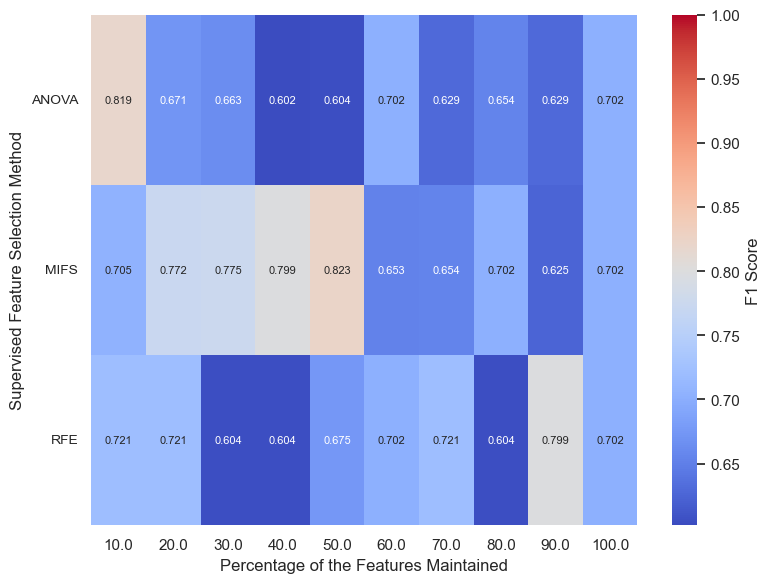

In [12]:
# test ALL OMICS dataset
results_all_omics = feature_selection_test(
    X_train_stan, Y_train, X_test_stan, Y_test)
# Add the MCC and F1 of model with no feature selection
metrics_none = logistic_model_all_omics.get_metrics(X_test_stan, Y_test)
results_all_omics = results_all_omics.append({
    'Method': 'None', 'F1': metrics_none['F1'], 'MCC': metrics_none['MCC'],
    'Number of Features': X_train.shape[1]}, ignore_index=True
)

Number of features selected by Boruta:  2


Running tests: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


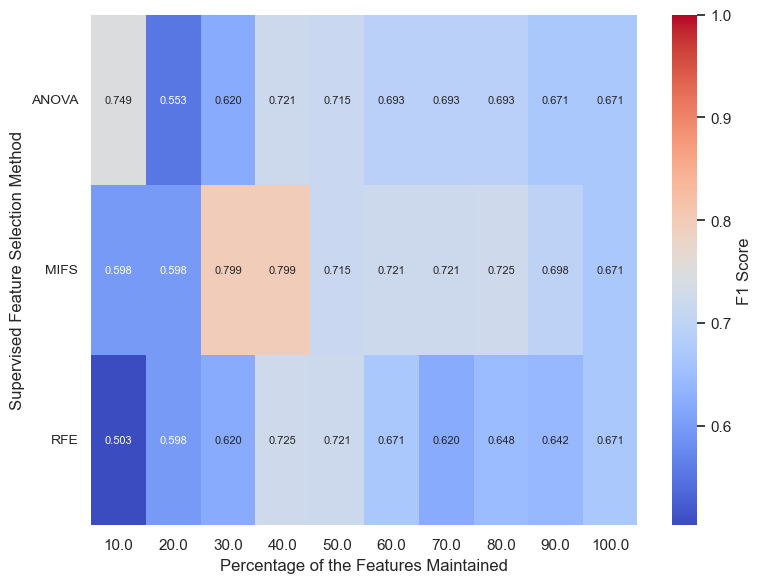

In [13]:
# test PROTEOMICS dataset
results_proteomics = feature_selection_test(
    proteomics_train_stan, Y_train, proteomics_test_stan, Y_test)
results_none_proteomics = logistic_model_proteomics.get_metrics(
    proteomics_test_stan, Y_test)
results_proteomics = results_proteomics.append({
    'Method': 'None', 'F1': results_none_proteomics['F1'], 
    'MCC': results_none_proteomics['MCC'],
    'Number of Features': proteomics_train.shape[1]}, ignore_index=True
)

In [14]:
RESULTS_PATH = "C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/"

In [15]:
# save the results as a csv
results_all_omics.to_csv(RESULTS_PATH + "results_all_omics.csv")
results_proteomics.to_csv(RESULTS_PATH + "results_proteomics.csv")

In [17]:
# Load the results
results_all_omics = pd.read_csv(RESULTS_PATH + "results_all_omics.csv")
results_proteomics = pd.read_csv(RESULTS_PATH + "results_proteomics.csv")

# Merge the results adding the Data column
results_all_omics['Data'] = 'All Omics'
results_proteomics['Data'] = 'Proteomics'
results = results_all_omics.append(results_proteomics)

Plot the results of feature selection testing.
With the following function different metrics can be plotted including _F1_, _MCC_, and the _number of features selected_.

In [18]:
def plot_metrics(results, metrics):
    """
    Plot the results of the feature selection testing.
    :param results: the results DataFrame
    :param metrics: the metric to plot (F1, MCC, Number of Features)
    """

    model_colors = {
        'ANOVA': '#003f5c', 'MIFS': '#58508d', 'RFE': '#bc5090',
        'Boruta Method': '#ff6361', 'None': '#ffa600',
    }
    plt.style.use("seaborn-v0_8")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plot the bars with fixed colors
    bars = []
    for model in results['Method'].unique():
        subset = results[results['Method'] == model]
        bar = sns.barplot(data=subset, x='Method', y=metrics, hue='Data', palette=[model_colors[model]], ax=ax, alpha=0.9, width=0.5)
        bars.append(bar)

    # Add hatches
    hatches = ['', '//']  # Define hatch patterns
    for i, thisbar in enumerate(ax.patches):
        hatch = hatches[i % 2]  # Apply hatches alternately
        # Set the color and hatch of the current bar
        thisbar.set_hatch(hatch)
        thisbar.set_edgecolor('white')

    # Customize plot
    ax.set_xlabel('Model', fontsize=12, weight='bold')
    ax.set_ylabel(metrics, fontsize=12, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    if metrics == "F1":
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
    elif metrics == "MCC":
        ax.set_ylim(-0.4, 0.7)
        ax.set_yticks(np.arange(-0.4, 0.7, 0.1))

    # Add annotations
    for p in ax.patches:
        if p.get_height() != 0:
            height = round(p.get_height(),2)
            if metrics == "Number of Features":
               height = int(height)
            ax.annotate(
                f"{height}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
    legend_handles = [
        Patch(facecolor='grey', edgecolor='white', hatch=hatches[0], label='Combined'),
        Patch(facecolor='grey', edgecolor='white', hatch=hatches[1], label='Proteomics')
    ]
    
    # Add custom legend
    ax.legend(
        handles=legend_handles, title='Data', title_fontsize='10', 
        fontsize='10', frameon=True, 
        # Shift legend up
        bbox_to_anchor=(0., 1.02, .2, .102), loc='lower right',
        ncol=1, mode='expand', borderaxespad=0.,
    )
    
    # Show plot
    plt.show()

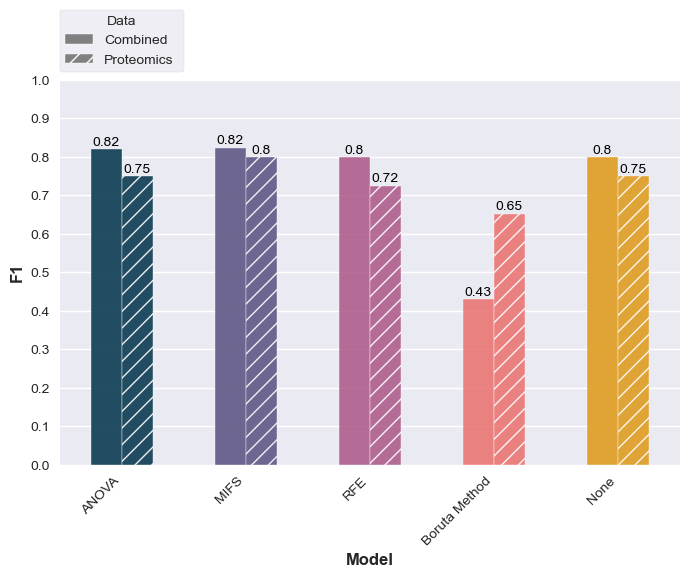

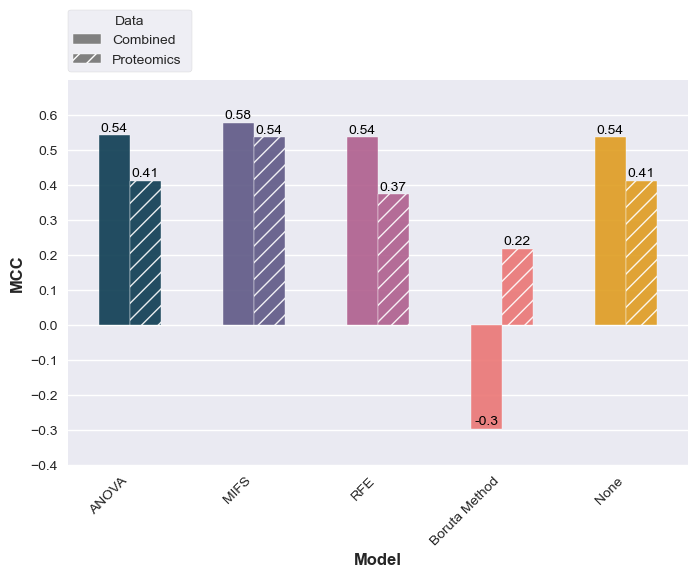

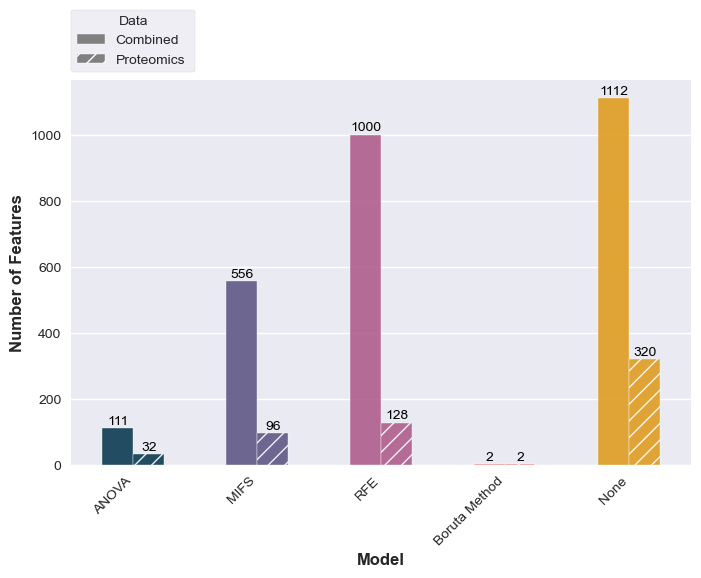

In [19]:
plot_metrics(results, 'F1')
plot_metrics(results, 'MCC')
plot_metrics(results, 'Number of Features')

Now I will retrieve the feature sets selected by different feature selection methods and plot the overlapping features.
First I will do that for the concatenated omics dataset and then for the proteomics dataset.

In [20]:
# Filter the features
MIFS_features = mutual_information_filtering(X_train, Y_train, 0.5)
RFE_features = recursive_feature_elimination(X_train, Y_train, 0.1)
ANOVA_features = ANOVA_correlation_filtering(X_train, Y_train, 0.3)
Boruta_features = boruta_filtering(X_train, Y_train)

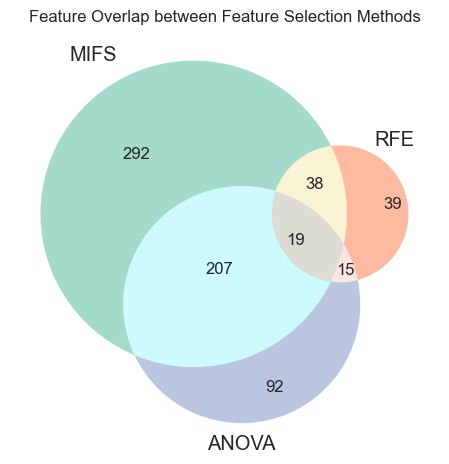

In [21]:
venn_diagram(
    [set(MIFS_features), set(RFE_features), set(ANOVA_features)],
    ['MIFS', 'RFE', 'ANOVA'], title="Feature Overlap between Feature Selection Methods",
    alpha=0.6
)

Now, I will use Venn diagram implementation from the R package as it can handle more than 3 sets.

In [22]:
%load_ext rpy2.ipython
# Activate the pandas2ri interface
pandas2ri.activate()

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: futile.logger



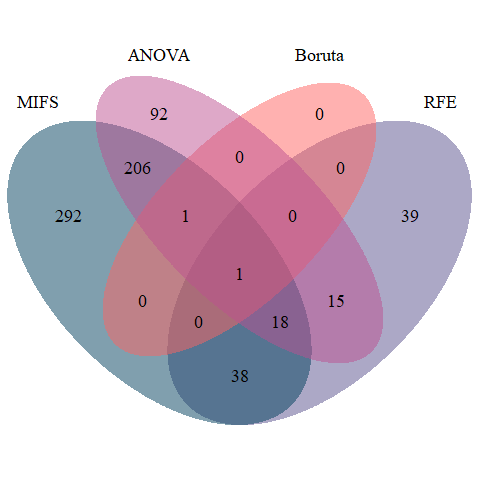

In [23]:
%%R -i MIFS_features -i RFE_features -i ANOVA_features -i Boruta_features
library(VennDiagram)
library(gridExtra)

# Venn diagram for concatinated omics dataset

# Create a list of the features
x = list(
    MIFS = MIFS_features, RFE = RFE_features,
    ANOVA = ANOVA_features, Boruta = Boruta_features)
# Define the colors
colors <- c('#003f5c', '#58508d','#bc5090', '#ff6361')

venn_plot <- venn.diagram(
    x = x,
    category.names = c("MIFS", "RFE", "ANOVA", "Boruta"),
    filename = NULL, output = FALSE, fill = colors, lty = 'blank',
    cex = 1.5,  # Increase text size for better readability
    cat.cex = 1.5  # Increase category labels size
)
# Plot the Venn diagram
grid.arrange(grobs = list(venn_plot))

In [24]:
# Filter proteomics dataset
MIFS_features_proteomics = mutual_information_filtering(proteomics_train, Y_train, 0.5)
RFE_features_proteomics = recursive_feature_elimination(proteomics_train, Y_train, 0.9)
ANOVA_features_proteomics = ANOVA_correlation_filtering(proteomics_train, Y_train, 0.1)
Boruta_features_proteomics = boruta_filtering(proteomics_train, Y_train)

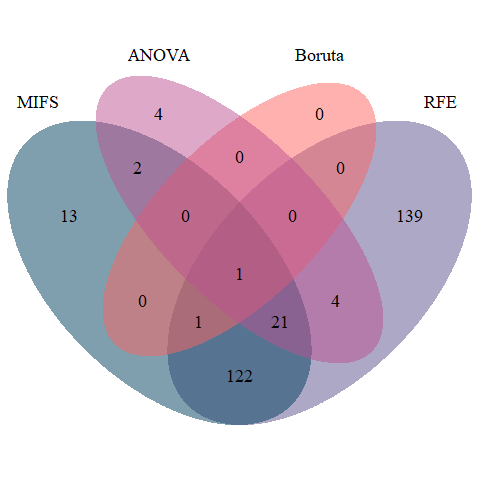

In [25]:
%%R -i MIFS_features_proteomics -i RFE_features_proteomics -i ANOVA_features_proteomics -i Boruta_features_proteomics
library(VennDiagram)
library(gridExtra)

# Venn diagram for proteomics dataset

x = list(
    MIFS = MIFS_features_proteomics, RFE = RFE_features_proteomics,
    ANOVA = ANOVA_features_proteomics, Boruta = Boruta_features_proteomics)
venn_plot <- venn.diagram(
    x = x,
    category.names = c("MIFS", "RFE", "ANOVA", "Boruta"),
    filename = NULL,
    output = TRUE,
    fill = c('#003f5c', '#58508d','#bc5090', '#ff6361'),
    lty = 'blank',
    cex = 1.5,  # Increase text size for better readability
    cat.cex = 1.5,  # Increase category labels size
)
grid.arrange(
    grobs = list(venn_plot)
)

### Investigating the best model
Now, I will look at the performance of the best model and the features selected by it.

In [26]:
# Tune the model
# c = LogisticRegressionModel().tune(X_train_stan[MIFS_features], Y_train)
# print(c)
# Create the model
best_logistic_model = LogisticRegressionModel(0.7)
best_logistic_model.fit(X_train_stan[MIFS_features], Y_train)

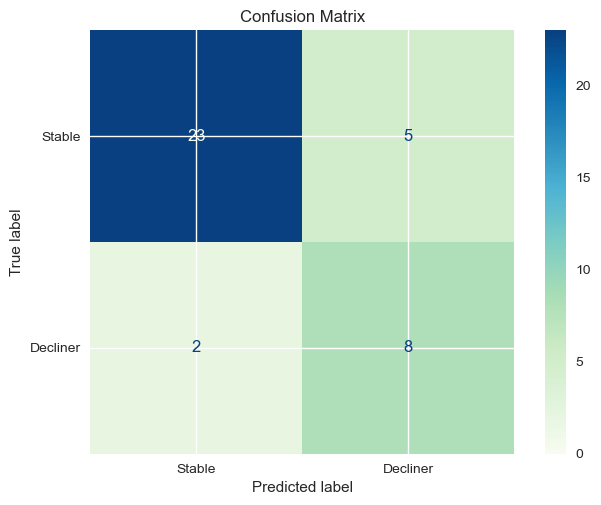

{'Accuracy': 0.816, 'F1': 0.823, 'Precision': 0.84, 'Recall': 0.816, 'AUC': 0.854, 'MCC': 0.577}


In [27]:
# Evaluate the model
best_logistic_metrics = best_logistic_model.get_metrics(
    X_test_stan[MIFS_features], Y_test, True)
print(best_logistic_metrics)

Save the features selected by this model

In [28]:
print("Number of all features: ", X_train.shape[1])
print("Number of Features Selected from MIFS: ", len(MIFS_features))

# Get non-zero coefficients
lasso_selection = best_logistic_model.model.coef_[0] != 0
# Get the names of the selected features
lasso_features = X_train[MIFS_features].columns[lasso_selection]
lasso_coefficients = best_logistic_model.model.coef_[0][lasso_selection]
lasso_omics_types = [get_omics_type(feature) for feature in lasso_features]
print("Number of Features Selected from LASSO: ", len(lasso_features))

Number of all features:  1112
Number of Features Selected from MIFS:  556
Number of Features Selected from LASSO:  38


In [29]:
# Map the feature IDs to correct names
new_lasso_features = []
for i in lasso_features:
    omics_type = get_omics_type(i)
    if omics_type == 'Proteomics':
        new_lasso_features.append(get_protein_name(i))
    elif omics_type == 'Metabolomics':
        new_lasso_features.append(get_metabolite_name(i))
    else:
        new_lasso_features.append(map_lipid_name(i))
        
# Save as a csv
lasso_df = pd.DataFrame({
    'Feature': new_lasso_features, 
    'Coefficient': lasso_coefficients, 
    'Omics': lasso_omics_types})
# Sort the dataframe by the absolute value of the coefficients
lasso_df = lasso_df.reindex(
    lasso_df['Coefficient'].abs().sort_values(ascending=False).index)
# Save the dataframe
lasso_df.to_csv(RESULTS_PATH + "best_model_features.csv")

{'Accuracy': 0.263, 'F1': 0.11, 'Precision': 0.069, 'Recall': 0.263, 'AUC': 0.854, 'MCC': 0.0}


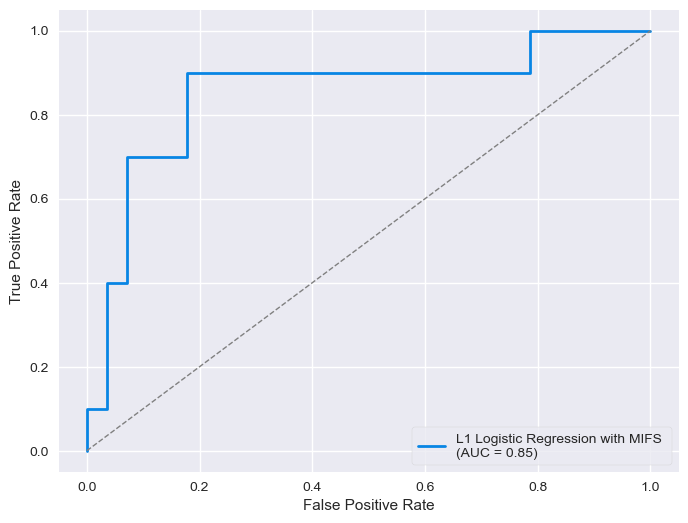

In [30]:
best_logistic_metrics = best_logistic_model.get_metrics(X_test[MIFS_features], Y_test)
print(best_logistic_metrics)

# Get the ROC curve data
fpr, tpr, _ = best_logistic_model.get_ROC(X_test[MIFS_features], Y_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr, color='#0885e4', lw=2,
    label=f'L1 Logistic Regression with MIFS \n(AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
# Update the legend to be in a box and positioned correctly
plt.legend(loc='lower right', frameon=True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# AdaBoost Model

In [31]:
class AdaBoostModel(Model):
    
    def __init__(self, seed=42, learning_rate=0.01, n_estimators=400):
        """
        Initialize the AdaBoost model.
        :param seed: the random seed
        :param learning_rate: How much the contribution of each classifier is reduced.
        :param n_estimators: The maximum number of estimators at which boosting is terminated.
        """
        super().__init__(seed)
        self.model = AdaBoostClassifier(
            n_estimators=n_estimators,
            random_state=seed,
            learning_rate=learning_rate
        )
        
    def tune(self, x_train, y_train):
        hyperparameters = {
            'n_estimators': [50, 100, 200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5]
        }
        grid_search = GridSearchCV(
            AdaBoostClassifier(random_state=self.seed),
            hyperparameters, cv=5, scoring='f1_weighted')
        grid_search.fit(x_train, y_train.values.ravel())
        self.model = grid_search.best_estimator_
        return grid_search.best_params_
        
    def fit(self, x_train, y_train):
        self.model.fit(x_train, y_train)
        
    def predict(self, x):
        return self.model.predict(x)
    
    def get_metrics(self, x_test, y_test, plot=False):
        y_pred = self.model.predict(x_test)
        y_pred_continuous = self.model.predict_proba(x_test)[:, 1]
        plot_confusion_matrix(y_test['TwoClass'], y_pred) if plot else None
        return {
            "Accuracy": round(accuracy_score(y_test, y_pred), 3),
            "F1": round(f1_score(y_test, y_pred, average='weighted'), 3),
            "Precision": round(precision_score(y_test, y_pred, average='weighted'), 3),
            "Recall": round(recall_score(y_test, y_pred, average='weighted'), 3),
            "AUC": round(roc_auc_score(y_test, y_pred_continuous), 3),
            "MCC": round(matthews_corrcoef(y_test, y_pred), 3)
        }

In [32]:
# ALL OMICS
# Tuning the hyperparameters
ada_tuning = AdaBoostModel().tune(X_train, Y_train)
print(ada_tuning)


KeyboardInterrupt



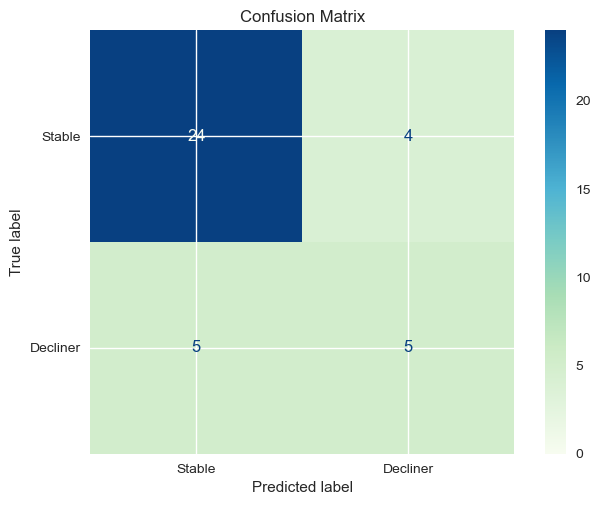

{'Accuracy': 0.763, 'F1': 0.759, 'Precision': 0.756, 'Recall': 0.763, 'AUC': 0.754, 'MCC': 0.37}


In [33]:
# ALL OMICS
# Tuning the hyperparameters
# ada_tuning = AdaBoostModel().tune(X_train, Y_train)
# print(ada_tuning)
ada_model_all_omics = AdaBoostModel(
    seed=42, learning_rate=0.05,
    n_estimators=200)
ada_model_all_omics.fit(X_train, Y_train)
ada_metrics_all_omics = ada_model_all_omics.get_metrics(X_test, Y_test, plot=True)
print(ada_metrics_all_omics)

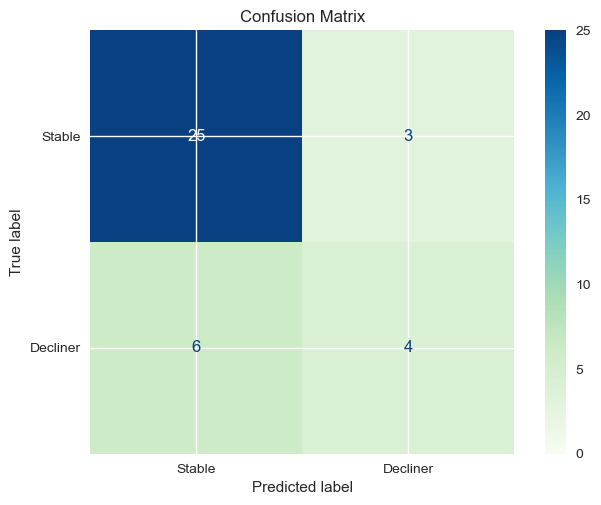

{'Accuracy': 0.763, 'F1': 0.748, 'Precision': 0.745, 'Recall': 0.763, 'AUC': 0.696, 'MCC': 0.333}


In [34]:
# PROTEOMICS
# Hyperparameter tuning
# ada_tuning = AdaBoostModel().tune(proteomics_train, Y_train)
# print(ada_tuning)
ada_model_proteomics = AdaBoostModel(
    seed=42, learning_rate=0.5,
    n_estimators=200)
ada_model_proteomics.fit(proteomics_train, Y_train)
ada_metrics_proteomics = ada_model_proteomics.get_metrics(proteomics_test, Y_test, plot=True)
print(ada_metrics_proteomics)

# Random Forest Model

In [35]:
class RandomForestModel(Model):
    
    def __init__(self, 
        seed=42, n_estimators=70, class_weight='balanced', 
        min_samples_leaf=1, min_samples_split=2, max_depth=None):
        super().__init__(seed)
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=seed,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            class_weight=class_weight
        )
        
    def fit(self, x_train, y_train):
        self.model.fit(x_train, y_train)
        
    def predict(self, x):
        return self.model.predict(x)
    
    def get_metrics(self, x_test, y_test, plot=False):
        y_pred = self.model.predict(x_test)
        y_pred_continuous = self.model.predict_proba(x_test)[:, 1]
        plot_confusion_matrix(y_test['TwoClass'], y_pred) if plot else None
        return {
            "Accuracy": round(accuracy_score(y_test, y_pred), 3),
            "F1": round(f1_score(y_test, y_pred, average='weighted'), 3),
            "Precision": round(precision_score(y_test, y_pred, average='weighted'), 3),
            "Recall": round(recall_score(y_test, y_pred, average='weighted'), 3),
            "AUC": round(roc_auc_score(y_test, y_pred_continuous), 3),
            "MCC": round(matthews_corrcoef(y_test, y_pred), 3)
        }
    
    def tune(self, x_train, y_train):
        hyperparameters = {
            'n_estimators': [50, 100, 200, 300, 400],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
        }
        grid_search = GridSearchCV(
            RandomForestClassifier(random_state=self.seed, max_depth=12, class_weight='balanced'),
            hyperparameters, cv=5, scoring='f1_weighted'
        )
        grid_search.fit(x_train, y_train.values.ravel())
        self.model = grid_search.best_estimator_
        return grid_search.best_params_

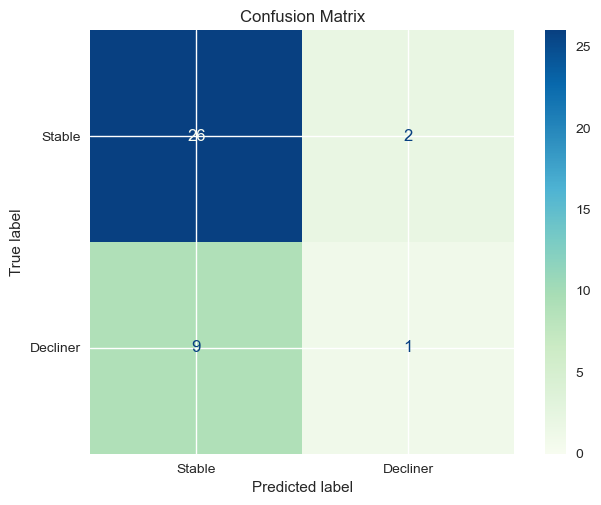

{'Accuracy': 0.711, 'F1': 0.649, 'Precision': 0.635, 'Recall': 0.711, 'AUC': 0.675, 'MCC': 0.047}


In [36]:
# Hyperparameter tuning
# rf_tuning = RandomForestModel().tune(X_train, Y_train)
# print(rf_tuning)
rf_model_all_omics = RandomForestModel(
    seed=42, n_estimators=200,
    min_samples_leaf=1,
    min_samples_split=2
)
rf_model_all_omics.fit(X_train, Y_train)
rf_metrics_all_omics = rf_model_all_omics.get_metrics(X_test, Y_test, plot=True)
print(rf_metrics_all_omics)

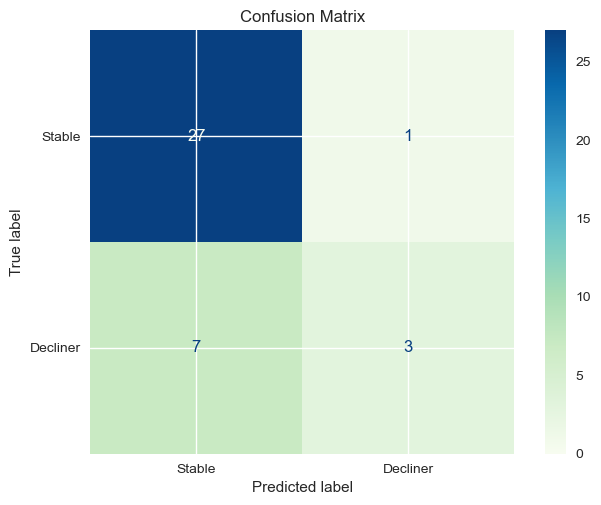

{'Accuracy': 0.789, 'F1': 0.755, 'Precision': 0.783, 'Recall': 0.789, 'AUC': 0.807, 'MCC': 0.379}


In [37]:
# PROTEOMICS
# Hyperparameter tuning
# rf_tuning = RandomForestModel().tune(proteomics_train, Y_train)
# print(rf_tuning)
rf_model_proteomics = RandomForestModel(
    seed=42, n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2
)
rf_model_proteomics.fit(proteomics_train, Y_train)
rf_metrics_proteomics = rf_model_proteomics.get_metrics(proteomics_test, Y_test, plot=True) 
print(rf_metrics_proteomics)

# PLS-DA Model

In [38]:
class PLS_DA_Model(Model):
    
    def __init__(self, n_components=4, seed=42):
        super().__init__(seed)
        self.model = PLSRegression(
            n_components=n_components, scale=False
        )
        
    def fit(self, train_x, train_y):
        self.model.fit(train_x, train_y)
        
    def predict(self, x):
        return self.model.predict(x)
        
    def get_metrics(self, x_test, y_test, plot=False):
        y_pred = self.model.predict(x_test)
        y_pred_continuous = y_pred[:, 0]
        y_pred_binary = np.where(y_pred_continuous > 0.5, 1, 0)
        plot_confusion_matrix(y_test['TwoClass'], y_pred_binary.flatten()) if plot else None
        return {
            "Accuracy": round(accuracy_score(y_test, y_pred_binary), 3),
            "F1": round(f1_score(y_test, y_pred_binary, average='weighted'), 3),
            "Precision": round(precision_score(y_test, y_pred_binary, average='weighted'), 3),
            "Recall": round(recall_score(y_test, y_pred_binary, average='weighted'), 3),
            "AUC": round(roc_auc_score(y_test, y_pred_continuous), 3),
            "MCC": round(matthews_corrcoef(y_test, y_pred_binary), 3)
        }
    
    def tune(self, x_train, y_train):
        hyperparameters = {
            'n_components': [3, 4, 5, 6, 7]
        }
        grid_search = GridSearchCV(
            PLSRegression(scale=False),
            hyperparameters, cv=5, scoring='f1_weighted'
        )
        grid_search.fit(x_train, y_train)
        self.model = grid_search.best_estimator_
        return grid_search.best_params_['n_components']
        
    def get_ROC(self, x_test, y_test):
        y_pred_continuous = self.model.predict(x_test)[:, 0]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_continuous)
        return fpr, tpr, thresholds

For PLS-DA normalized data should be used.

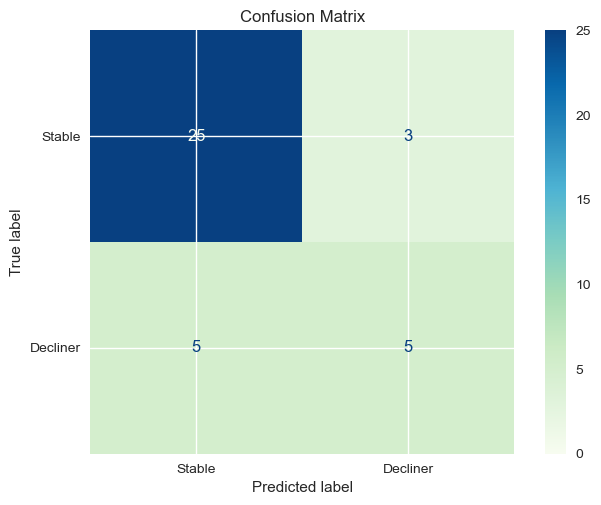

{'Accuracy': 0.789, 'F1': 0.781, 'Precision': 0.779, 'Recall': 0.789, 'AUC': 0.679, 'MCC': 0.424}


In [39]:
# ALL OMICS
# Hyperparameter tuning
pls_model_all_omics = PLS_DA_Model(4)
pls_model_all_omics.fit(X_train_stan, Y_train)
pls_metrics_all_omics = pls_model_all_omics.get_metrics(X_test_stan, Y_test, plot=True)
print(pls_metrics_all_omics)

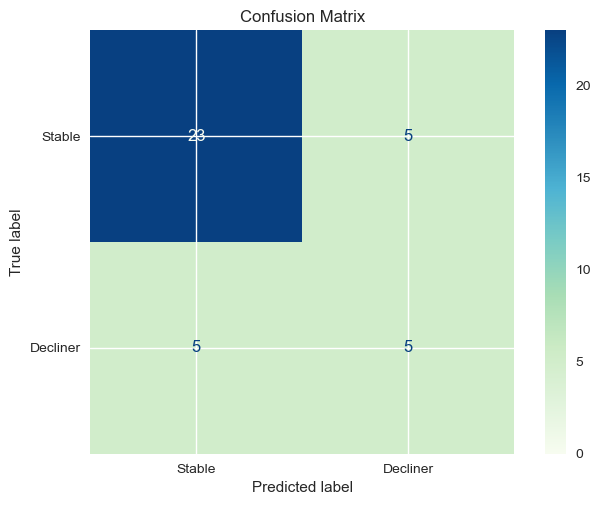

{'Accuracy': 0.737, 'F1': 0.737, 'Precision': 0.737, 'Recall': 0.737, 'AUC': 0.675, 'MCC': 0.321}


In [40]:
# PROTEOMICS
# Hyperparameter tuning
pls_model_proteomics = PLS_DA_Model(4)
pls_model_proteomics.fit(proteomics_train_stan, Y_train)
pls_metrics_proteomics = pls_model_proteomics.get_metrics(proteomics_test_stan, Y_test, plot=True)
print(pls_metrics_proteomics)

# sPLS-DA Model

In [41]:
%load_ext rpy2.ipython
# Activate the pandas2ri interface
pandas2ri.activate()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [42]:
class sPLS_DA_Model(Model):
    
    def __init__(self, seed=42, components=3, keepX=None):
        super().__init__(seed)
        self.keepX = keepX
        self.components = components
        self.final_sPLSDA = None
                 
    def fit(self, train_x, train_y):
        
        # Pass data to R
        r.assign('X_train', pandas2ri.py2rpy(train_x))
        r.assign('Y_train', pandas2ri.py2rpy(train_y['TwoClass']))
        r.assign('ncomp', self.components)
        r.assign('keepX', pandas2ri.py2rpy(pd.Series(self.keepX)))
        
        r('''
        suppressMessages({
            library(mixOmics)
            library(pROC)
            
            Y_train <- as.factor(Y_train)
            final_sPLSDA <- splsda(X = X_train, Y = Y_train, ncomp = ncomp, keepX = keepX)
        })
        ''')
        self.final_sPLSDA = r['final_sPLSDA']
        
    def predict(self, x):
        r.assign('X.test', x)
        r.assign('final.sPLSDA', self.final_sPLSDA)
        r.assign('ncomp', self.components)
        r('''
        suppressMessages({
            Y.pred <- predict(final.sPLSDA, newdata=X.test)
            pred <- predict(
                object = final.sPLSDA, newdata = X.test, 
                dist = "mahalanobis.dist", prob = TRUE)
            pred_binary <- as.numeric(pred$MajorityVote$mahalanobis.dist[, ncomp])
            pred_cont <- pred$predic[, 2, ncomp]
            })
        ''')
        return r.get('pred_binary'), r.get('pred_cont')
    
    def get_metrics(self, x_test, y_test, plot=False):
        pred_binary, pred_cont = self.predict(x_test)
        plot_confusion_matrix(y_test['TwoClass'].values, pred_binary) if plot else None
        return {
            "Accuracy": round(accuracy_score(y_test, pred_binary), 3),
            "F1": round(f1_score(y_test, pred_binary, average='weighted'), 3),
            "Precision": round(precision_score(y_test, pred_binary, average='weighted'), 3),
            "Recall": round(recall_score(y_test, pred_binary, average='weighted'), 3),
            "AUC": round(roc_auc_score(y_test, pred_cont), 3),
            "MCC": round(matthews_corrcoef(y_test, pred_binary), 3)
        }
    
    def get_ROC(self, x_test, y_test):
        pred_binary, pred_cont = self.predict(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, pred_cont)
        return fpr, tpr, thresholds

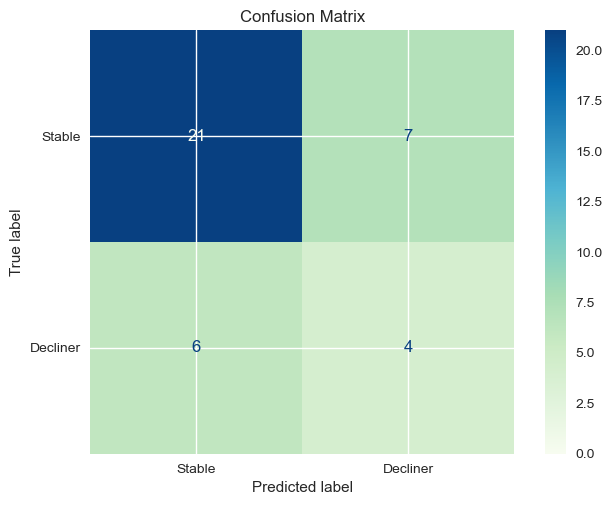

{'Accuracy': 0.658, 'F1': 0.663, 'Precision': 0.669, 'Recall': 0.658, 'AUC': 0.682, 'MCC': 0.146}


In [43]:
# ALL OMICS
# Here tuning has to be done in different file (look PLS_binary notebook)
sPLS_DA_model_all_omics = sPLS_DA_Model(42, 3, [21, 361, 481])
sPLS_DA_model_all_omics.fit(X_train, Y_train)
sPLS_DA_metrics_all_omics = sPLS_DA_model_all_omics.get_metrics(
    X_test, Y_test, plot=True)
print(sPLS_DA_metrics_all_omics)

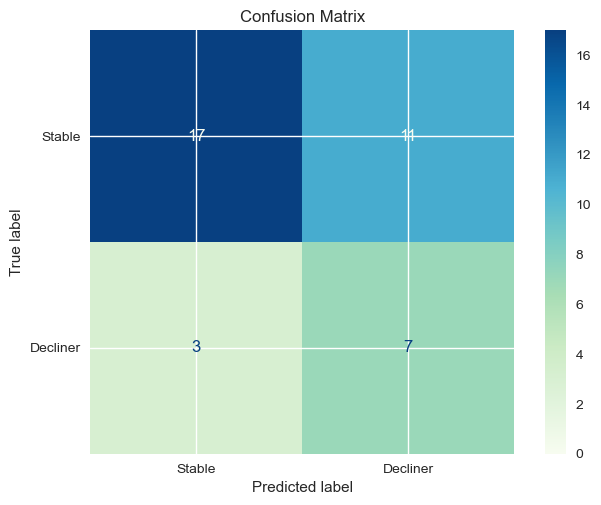

{'Accuracy': 0.632, 'F1': 0.654, 'Precision': 0.729, 'Recall': 0.632, 'AUC': 0.729, 'MCC': 0.271}


In [44]:
# PROTEOMICS
sPLS_DA_model_proteomics = sPLS_DA_Model(42, 2, [21, 301])
sPLS_DA_model_proteomics.fit(proteomics_train, Y_train)
sPLS_DA_metrics_proteomics = sPLS_DA_model_proteomics.get_metrics(
    proteomics_test, Y_test, plot=True)
print(sPLS_DA_metrics_proteomics)

# Testing DIABLO Model

In [45]:
class DIABLO_model:
    
    def get_ROC(self, proteomics_, metabolomics_, lipidomics_, Y_):
        _, pred_cont_ = self.compute_DIABLO(
            proteomics_, metabolomics_, lipidomics_, Y_)
        fpr, tpr, thresholds = roc_curve(Y_[1], pred_cont_)
        return fpr, tpr, thresholds
    
    
    def get_metrics(self, proteomics_, metabolomics_, lipidomics_, Y_, plot=False):
        pred_binary_ = self.compute_DIABLO(
            proteomics_, metabolomics_, lipidomics_, Y_)
        plot_confusion_matrix(Y_[1]['TwoClass'], pred_binary_) if plot else None
        return {
            'F1': round(f1_score(Y_[1], pred_binary_, average='weighted'), 3),  
            "Recall": round(recall_score(Y_[1], pred_binary_, average='weighted'), 3),
            "Precision": round(precision_score(Y_[1], pred_binary_, average='weighted'), 3),
            "Accuracy": round(accuracy_score(Y_[1], pred_binary_), 3),
            "MCC": round(matthews_corrcoef(Y_[1], pred_binary_), 3),
        }
    
    def compute_DIABLO(self, proteomics_, metabolomics_, lipidomics_, Y_):
        # Pass data to R
        r.assign('lipidomics_train', lipidomics_[0])
        r.assign('metabolomics_train', metabolomics_[0])
        r.assign('proteomics_train', proteomics_[0])
        r.assign('Y_train', Y_[0])
        
        r.assign('lipidomics_test', lipidomics_[1])
        r.assign('metabolomics_test', metabolomics_[1])
        r.assign('proteomics_test', proteomics_[1])
        
        # Execute R code
        r('''
        suppressMessages({
            library(mixOmics)
            library(pROC)
            
            # GLOBAL VARIABLES (the ones that I have tuned)
            ncomp <- 4
            # Keep x for each data type
            lipidomics_keepX <- c(347, 5, 5, 5)
            metabolomics_keepX <- c(44, 23, 191, 86)
            proteomics_keepX <- c(35, 131, 99, 163)
            
            list.keepX <- list(
              Lipidomics = lipidomics_keepX,
              Metabolomics = metabolomics_keepX,
              Proteomics = proteomics_keepX
            )
            
            relation_lip_prot <- 0.6134237
            relation_met_prot <- 0.5298697
            relation_met_lip <- 0.9326519
            
            # Convert Y to factor
            Y.train <- as.numeric(Y_train$TwoClass)
            
            X.train <- list(
                Metabolomics = metabolomics_train, 
                Lipidomics = lipidomics_train, 
                Proteomics = proteomics_train)
            X.test <- list(
                Metabolomics = metabolomics_test, 
                Lipidomics = lipidomics_test, 
                Proteomics = proteomics_test)
    
            names <- c("Metabolomics", "Lipidomics", "Proteomics")
            design = matrix(0, ncol=3, nrow=3, dimnames = list(names, names))
            diag(design) = 0 # set diagonal to 0s
            
            design["Metabolomics", "Lipidomics"] <- relation_met_lip
            design["Lipidomics", "Metabolomics"] <- relation_met_lip
            design["Metabolomics", "Proteomics"] <- relation_met_prot
            design["Proteomics", "Metabolomics"] <- relation_met_prot
            design["Lipidomics", "Proteomics"] <- relation_lip_prot
            design["Proteomics", "Lipidomics"] <- relation_lip_prot
            
            final.diablo = block.splsda(
               X=X.train, Y=Y.train, design=design, ncomp = ncomp, keepX = list.keepX
            )
            predict.diablo = predict(final.diablo, newdata = X.test)
            pred_binary <- as.numeric(
                predict.diablo$WeightedVote$mahalanobis.dist[,ncomp])
            
            # Get the AUC score
            pred_cont <- predict.diablo$variates$Metabolomics[, ncomp]
        })
        ''')
        return r.get('pred_binary')

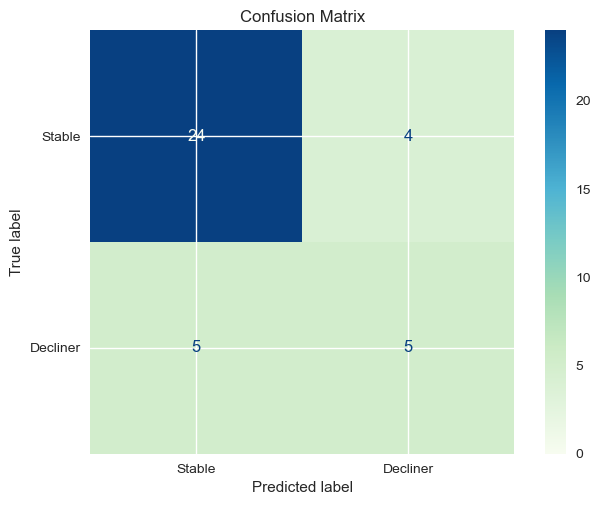

{'F1': 0.759, 'Recall': 0.763, 'Precision': 0.756, 'Accuracy': 0.763, 'MCC': 0.37}


In [46]:
diablo_model = DIABLO_model()
diablo_model.compute_DIABLO(
    [proteomics_train, proteomics_test],
    [metabolomics_train, metabolomics_test],
    [lipidomics_train, lipidomics_test],
    [Y_train, Y_test])
diablo_metrics_all_omics = diablo_model.get_metrics(
    [proteomics_train, proteomics_test], 
    [metabolomics_train, metabolomics_test],
    [lipidomics_train, lipidomics_test],
    [Y_train, Y_test], plot=True)
print(diablo_metrics_all_omics)

# Summarizing the results

Now I will combine the results from all the models and plot them.


In [47]:
def get_metric_df(metric):
    models = [
         'Logistic Regression', 'PLS-DA', 'sPLS-DA', 
         'AdaBoost', 'Random Forest', 'DIABLO'
    ]
    scores_all_omics = [
        metric_logistic_all_omics[metric], pls_metrics_all_omics[metric], 
        sPLS_DA_metrics_all_omics[metric], ada_metrics_all_omics[metric], 
        rf_metrics_all_omics[metric], diablo_metrics_all_omics[metric]]

    scores_proteomics = [
        metric_logistic_proteomics[metric], pls_metrics_proteomics[metric], 
        sPLS_DA_metrics_proteomics[metric], ada_metrics_proteomics[metric],
        rf_metrics_proteomics[metric], 0]
    
    return pd.DataFrame(
    {
        'Model': models * 2, metric: scores_all_omics + scores_proteomics, 
        'Omics': ['All Omics'] * 6 + ['Proteomics'] * 6})

In [48]:
df = get_metric_df('F1')
# Split the data into two groups
all_omics_scores = df[df['Omics'] == 'All Omics']['F1']
proteomics_scores = df[df['Omics'] == 'Proteomics']['F1']

# Perform the paired t-test
t_stat, p_value = ttest_rel(all_omics_scores, proteomics_scores)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("The difference in F1 scores between combined omics and proteomics is statistically significant.")
else:
    print("The difference in F1 scores between combined omics and proteomics is not statistically significant.")


T-statistic: 0.9962818614829476
P-value: 0.3648541057046711
The difference in F1 scores between combined omics and proteomics is not statistically significant.


In [49]:
def plot_scores(metric, scores_df):
    """
    Plot the scores for different models and omics datasets.
    :param metric: The metric to plot (F1, MCC)
    :param scores_df: The dataframe containing the scores
    """
    # Plot the results
    plt.style.use("seaborn-v0_8")
    
    # "#ebdc78"
    model_colors = {
        'Logistic Regression' : "#b30000", 
        'PLS-DA': "#7c1158", 
        'sPLS-DA': "#4421af", 
        'AdaBoost': "#1a53ff", 
        'Random Forest': "#00b7c7", 
        'DIABLO': "#5ad45a"
    }

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = []
    for model in scores_df['Model'].unique():
        subset = scores_df[scores_df['Model'] == model]
        bar = sns.barplot(
            data=subset, x='Model', y=metric, hue='Omics', 
            palette=[model_colors[model]], ax=ax, alpha=0.9, width=0.5)
        bars.append(bar)

    # Add hatches
    hatches = ['', '//']  # Define hatch patterns
    for i, thisbar in enumerate(ax.patches):
        hatch = hatches[i % 2]  # Apply hatches alternately
        thisbar.set_hatch(hatch)
    
    # Customize plot
    ax.set_xlabel('Model', fontsize=12, weight='bold')
    ax.set_ylabel(metric, fontsize=12, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_ylim(0., 1)
    if metric != "MCC":
        ax.set_yticks(np.arange(0, 1.1, 0.1))
    else:
        # Set limits for MCC
        ax.set_ylim(0., 0.6)
        ax.set_yticks(np.arange(0, 0.6, 0.1))

    # Add annotations
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                          textcoords='offset points')
    
    legend_handles = [
        Patch(facecolor='grey', edgecolor='white', hatch=hatches[0], label='Combined'),
        Patch(facecolor='grey', edgecolor='white', hatch=hatches[1], label='Proteomics')
    ]

    # Add custom legend
    ax.legend(
        handles=legend_handles, title='Data', title_fontsize='10', 
        fontsize='10', frameon=True, 
        # Shift legend up
        bbox_to_anchor=(0., 1.02, .2, .102), loc='lower right',
        ncol=1, mode='expand', borderaxespad=0.,
    )
    
    # Show plot
    plt.show()


def plot_model_metric(metric):
    """
    Extract the metric dataframe and plot the results.
    :param metric: The metric to plot (F1, MCC)
    :return: None
    """
    scores_df = get_metric_df(metric)
    plot_scores(metric, scores_df)

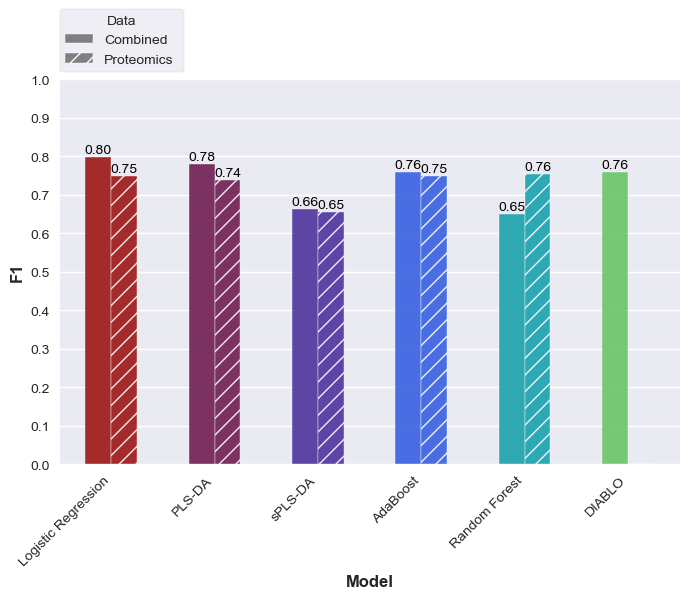

In [115]:
plot_model_metric('F1')

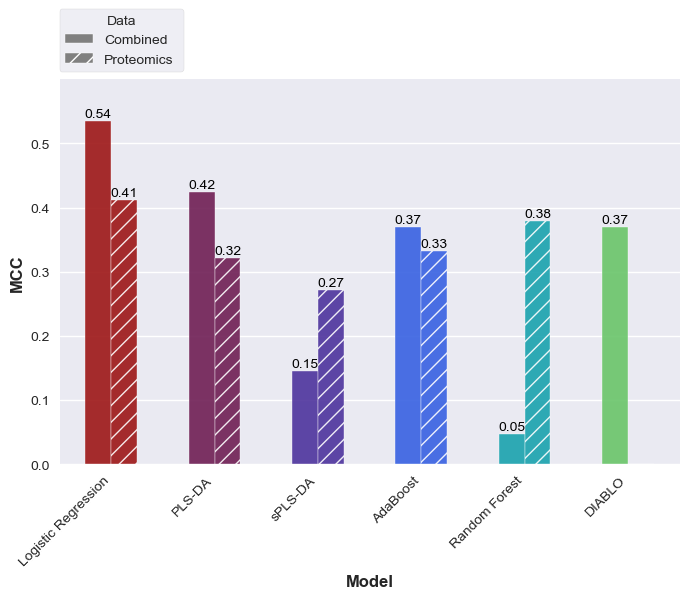

In [116]:
plot_model_metric('MCC')

**ROC Curve**
Addtionally, I will plot the ROC curve for the models (except DIABLO) and compare them.

In [59]:
# Compare the performances of the best model on multi omics data and single proteomics data
# Get the confusion matrices
multi_omics_pred = logistic_model_all_omics.predict(X_test_stan)
print(logistic_model_all_omics.get_metrics(X_test_stan, Y_test))
proteomics_pred = rf_model_proteomics.predict(proteomics_test)
print(rf_model_proteomics.get_metrics(proteomics_test, Y_test))
cm = confusion_matrix(multi_omics_pred, proteomics_pred)

print()
print(cm)

# Perform the McNemar's test
result = mcnemar(cm, exact=True)
print(f"McNemar's test statistic: {result.statistic}")
print(f"McNemar's test p-value: {result.pvalue}")

# Interpret the result
alpha = 0.05
if result.pvalue < alpha:
    print('Significant difference between models (reject H0)')
else:
    print('No significant difference between models (fail to reject H0)')

{'Accuracy': 0.789, 'F1': 0.799, 'Precision': 0.826, 'Recall': 0.789, 'AUC': 0.746, 'MCC': 0.535}
{'Accuracy': 0.789, 'F1': 0.755, 'Precision': 0.783, 'Recall': 0.789, 'AUC': 0.807, 'MCC': 0.379}

[[23  1]
 [11  3]]
McNemar's test statistic: 1.0
McNemar's test p-value: 0.00634765625
Significant difference between models (reject H0)


In [119]:
# All omics data
# Extract the ROC data
fpr_log, tpr_log, _ = logistic_model_all_omics.get_ROC(X_test, Y_test)
auc_logistic = auc(fpr_log, tpr_log)
fpr_pls, tpr_pls, _ = pls_model_all_omics.get_ROC(X_test, Y_test)
auc_pls = auc(fpr_pls, tpr_pls)
fpr_spls, tpr_spls, _ = sPLS_DA_model_all_omics.get_ROC(X_test, Y_test)
auc_spls = auc(fpr_spls, tpr_spls)
fpr_ada, tpr_ada, _ = ada_model_all_omics.get_ROC(X_test, Y_test)
auc_ada = auc(fpr_ada, tpr_ada)
fpr_rf, tpr_rf, _ = rf_model_all_omics.get_ROC(X_test, Y_test)
auc_rf = auc(fpr_rf, tpr_rf)

# Single proteomics models
# Extract the ROC data
proteomics_fpr_log, proteomics_tpr_log, _ = logistic_model_proteomics.get_ROC(
    proteomics_test, Y_test)
proteomics_auc_log = auc(proteomics_fpr_log, proteomics_tpr_log)

proteomics_fpr_pls, proteomics_tpr_pls, _ = pls_model_proteomics.get_ROC(
    proteomics_test, Y_test)
proteomics_auc_pls = auc(proteomics_fpr_pls, proteomics_tpr_pls)

proteomics_fpr_spls, proteomics_tpr_spls, _ = sPLS_DA_model_proteomics.get_ROC(
    proteomics_test, Y_test)
proteomics_auc_spls = auc(proteomics_fpr_spls, proteomics_tpr_spls)

proteomics_fpr_ada, proteomics_tpr_ada, _ = ada_model_proteomics.get_ROC(
    proteomics_test, Y_test)
proteomics_auc_ada = auc(proteomics_fpr_ada, proteomics_tpr_ada)

proteomics_fpr_rf, proteomics_tpr_rf, _ = rf_model_proteomics.get_ROC(
    proteomics_test, Y_test)
proteomics_auc_rf = auc(proteomics_fpr_rf, proteomics_tpr_rf)

### Roc Curve Plots

First I will plot it for all omics and then for the single proteomics datasets.

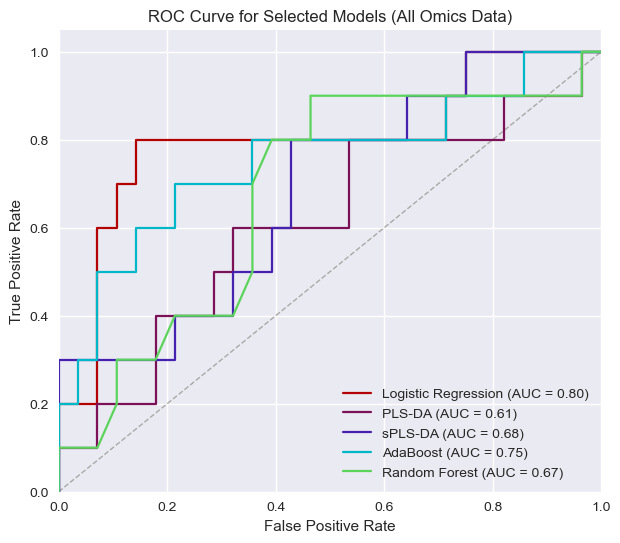

In [121]:
colors = ["#b30000", "#7c1158", "#4421af", "#1a53ff", "#00b7c7", "#5ad45a","#ebdc78"]

# set the style matplotlib
plt.style.use('seaborn-v0_8')
# Create the plot
plt.figure(figsize=(7, 6))
lw = 1.6

# Plot the diagonal line for no-skill classifier
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--', lw=1)

# Logistic Regression
plt.plot(fpr_log, tpr_log, 
    label=f'Logistic Regression (AUC = {auc_logistic:.2f})', color=colors[0], lw=lw)
# PLS-DA
plt.plot(fpr_pls, tpr_pls, 
    label=f'PLS-DA (AUC = {auc_pls:.2f})', color=colors[1], lw=lw)
# sPLS-DA
plt.plot(fpr_spls, tpr_spls, 
    label=f'sPLS-DA (AUC = {auc_spls:.2f})', color=colors[2], lw=lw)
# AdaBoost
plt.plot(fpr_ada, tpr_ada, 
    label=f'AdaBoost (AUC = {auc_ada:.2f})', color=colors[4], lw=lw)

# Random Forest
plt.plot(fpr_rf, tpr_rf, 
    label=f'Random Forest (AUC = {auc_rf:.2f})', color=colors[5], lw=lw)

# Setting plot attributes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Selected Models (All Omics Data)')
plt.legend(loc='lower right')
plt.show()

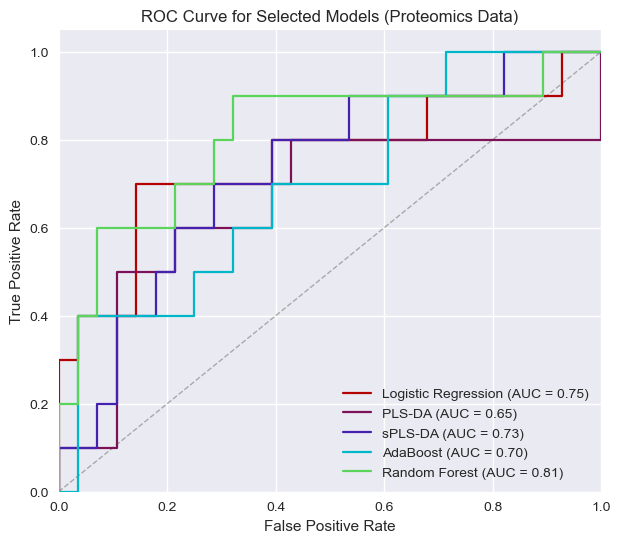

In [122]:
# Now I will plot the ROC curve for the single proteomics datasets.

# Create the plot
plt.figure(figsize=(7, 6))

# Plot the diagonal line for no-skill classifier
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--', lw=1)

# Logistic Regression
plt.plot(proteomics_fpr_log, proteomics_tpr_log, 
    label=f'Logistic Regression (AUC = {proteomics_auc_log:.2f})', color=colors[0], lw=lw)
# PLS-DA
plt.plot(proteomics_fpr_pls, proteomics_tpr_pls, 
    label=f'PLS-DA (AUC = {proteomics_auc_pls:.2f})', color=colors[1], lw=lw)
# sPLS-DA
plt.plot(proteomics_fpr_spls, proteomics_tpr_spls, 
    label=f'sPLS-DA (AUC = {proteomics_auc_spls:.2f})', color=colors[2], lw=lw)
# AdaBoost
plt.plot(proteomics_fpr_ada, proteomics_tpr_ada, 
    label=f'AdaBoost (AUC = {proteomics_auc_ada:.2f})', color=colors[4], lw=lw)
# Random Forest
plt.plot(proteomics_fpr_rf, proteomics_tpr_rf, 
    label=f'Random Forest (AUC = {proteomics_auc_rf:.2f})', color=colors[5], lw=lw)

# Setting plot attributes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Selected Models (Proteomics Data)')
plt.legend(loc='lower right')
plt.show()